In [18]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sampex_microburst_indices.load.catalog import Catalog
from sampex_microburst_indices.analysis.dial import Dial

Load the CSV file, parse the time stamps, remove rows with unfilled attitude data, and removes spin times.

In [2]:
cat = Catalog(0, parse_dates=True).load()

In [3]:
print(cat.columns, '\n', cat.shape)

Index(['burst_param', 'date', 'GEO_Long', 'GEO_Lat', 'Altitude', 'L_Shell',
       'MLT', 'Att_Flag', 'Pitch', 'AE', 'AL', 'AU', 'SYM/D', 'SYM/H', 'ASY/D',
       'ASY/H'],
      dtype='object') 
 (244020, 16)


In [4]:
cat.head()

,burst_param,date,GEO_Long,GEO_Lat,Altitude,L_Shell,MLT,Att_Flag,Pitch,AE,AL,AU,SYM/D,SYM/H,ASY/D,ASY/H
dateTime,,,,,,,,,,,,,,,,
1997-11-09 19:56:40.720,35.3,1997-11-09,108.686,69.4370,681.303,5.47977,3.30990,0.0,32.9061,660.0,-518.0,142.0,-5.0,-16.0,23.0,42.0
1997-11-09 19:56:46.920,16.5,1997-11-09,109.084,69.1038,681.373,5.34191,3.33664,0.0,32.8835,660.0,-518.0,142.0,-5.0,-16.0,23.0,42.0
1997-11-09 19:57:02.440,10.4,1997-11-09,110.202,68.0984,681.558,4.99033,3.41316,0.0,32.8191,660.0,-518.0,142.0,-5.0,-16.0,23.0,42.0
1997-11-09 19:57:02.760,10.2,1997-11-09,110.202,68.0984,681.558,4.99033,3.41316,0.0,32.8191,660.0,-518.0,142.0,-5.0,-16.0,23.0,42.0
1997-11-09 19:57:02.980,10.4,1997-11-09,110.202,68.0984,681.558,4.99033,3.41316,0.0,32.8191,660.0,-518.0,142.0,-5.0,-16.0,23.0,42.0


In [5]:
cat['dt'] = cat.index.to_series().diff().dt.total_seconds()
# cat = cat.dropna()
cat['dt']

dateTime
1997-11-09 19:56:40.720          NaN
1997-11-09 19:56:46.920         6.20
1997-11-09 19:57:02.440        15.52
1997-11-09 19:57:02.760         0.32
1997-11-09 19:57:02.980         0.22
                             ...    
2007-08-11 19:25:55.640         6.76
2007-08-11 19:25:55.900         0.26
2007-08-11 19:25:55.940         0.04
2007-08-11 19:25:56.240         0.30
2007-08-22 14:22:12.900    932176.66
Name: dt, Length: 244020, dtype: float64

The peak of the dt distribution is at 0.327 s.


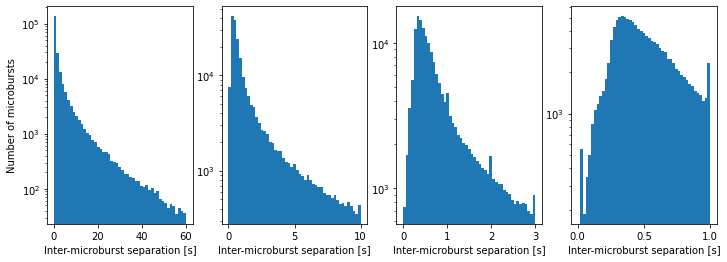

In [6]:
fig, ax = plt.subplots(1, 4, figsize=(12, 4))
ax[0].hist(cat['dt'], bins=np.linspace(0, 60))
ax[1].hist(cat['dt'], bins=np.linspace(0, 10))
ax[2].hist(cat['dt'], bins=np.linspace(0, 3))
ax[3].hist(cat['dt'], bins=np.linspace(0, 1))

for ax_i in ax:
    ax_i.set_yscale('log');
    ax_i.set_xlabel('Inter-microburst separation [s]')
ax[0].set_ylabel('Number of microbursts')

H, bins = np.histogram(cat['dt'], bins=np.linspace(0, 2))
print(f'The peak of the dt distribution is at {round(bins[np.argmax(H)], 3)} s.')


As we zoomed in, we found that the dt distribution is peaked at ~0.3 seconds.

In [7]:
np.nanquantile(cat['dt'], q=(0.25, .50, 0.75))

array([0.46, 0.96, 4.2 ])

Helper function for a progress bar.

In [8]:
def progressbar(i, n):
    # Update the status % in the terminal.
    progress_percent = round(100 * i / n)
    progress_str = "#" * (progress_percent // 5)
    print(f'Calculating intervals: |{progress_str:<20}| {progress_percent}%', end='\r')
    return

# Calculate the microburst trains
First define a maximum time threshold between microbursts to qualify as a microburst train

In [9]:
threshold_s = 0.5

In [10]:
def intervals(dt, threshold_s=1):
    """
    Given a list of time differences, dt, calculate the start and end indices for
    intervals where dt < threshold_s (units of seconds). 
    """
    i = 0
    indices = np.zeros((0, 2), dtype=int)

    while i < len(dt):

        progressbar(i, len(dt))        

        if (dt[i] > threshold_s) or np.isnan(dt[i]):
            i += 1
            continue
        else:
            j = i
            if j == len(dt):
                break
            while dt[j] <= threshold_s:
                j += 1
            # This assumes pandas's inclusive index slicing. 
            # Change j-1 to j for numpy indexing.
            indices = np.vstack((indices, [i-1, j-1]))
            i = j
    # Add a newline to avoid merging the progress bar text and the next print line.
    print()  
    return indices
    
indices = intervals(cat['dt'], threshold_s=threshold_s)
indices

Calculating intervals: |####################| 100%


array([[     2,      4],
       [    15,     16],
       [    27,     28],
       ...,
       [244003, 244004],
       [244010, 244013],
       [244015, 244018]])

Visually check that the first few indices match to the correct dt.

In [11]:
cat['dt'].reset_index().iloc[:20]

,dateTime,dt
0,1997-11-09 19:56:40.720,NaN
1,1997-11-09 19:56:46.920,6.20
2,1997-11-09 19:57:02.440,15.52
3,1997-11-09 19:57:02.760,0.32
4,1997-11-09 19:57:02.980,0.22
5,1997-11-09 19:57:09.720,6.74
6,1997-11-09 20:42:16.280,2706.56
7,1997-11-10 00:31:21.700,13745.42
8,1997-11-10 00:47:48.780,987.08
9,1997-11-10 01:20:27.020,1958.24


## Calculate train values

In [12]:
trains = pd.DataFrame(
    data=np.nan*np.zeros((indices.shape[0], len(cat.columns)+1)),
    index=cat.index[indices[:,0]],
    columns=np.concatenate((cat.columns.to_numpy(), ['n_microbursts']))
)

In [13]:
for i, (start, end) in enumerate(indices):
    progressbar(i, indices.shape[0]) 
    trains.loc[cat.index[start], cat.columns] = cat.iloc[start:end, :].mean()
    # The +1 is to avoid averaging the dt from the previous gap
    trains.loc[cat.index[start], 'dt'] = cat.loc[cat.index[start+1]:cat.index[end], 'dt'].mean()
    trains.loc[cat.index[start], 'n_microbursts'] = end-start+1
trains.drop(columns=['burst_param', 'date'], inplace=True)

Calculating intervals: |                    | 0%

/tmp/ipykernel_2964/2220798002.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  trains.loc[cat.index[start], cat.columns] = cat.iloc[start:end, :].mean()


In [16]:
trains.shape

(40223, 16)

In [14]:
trains.head()

,GEO_Long,GEO_Lat,Altitude,L_Shell,MLT,Att_Flag,Pitch,AE,AL,AU,SYM/D,SYM/H,ASY/D,ASY/H,dt,n_microbursts
dateTime,,,,,,,,,,,,,,,,
1997-11-09 19:57:02.440,110.202000,68.0984,681.558000,4.990330,3.413160,0.0,32.819100,660.0,-518.0,142.0,-5.0,-16.0,23.0,42.0,0.27,3.0
1997-11-10 04:52:25.180,165.728000,-53.0439,531.669000,4.694220,17.458500,0.0,155.921000,257.0,-58.0,199.0,4.0,-43.0,32.0,33.0,0.40,2.0
1997-11-14 12:38:19.000,215.561000,62.1377,681.167000,5.360510,2.232920,0.0,45.875000,405.0,-340.0,65.0,4.0,-22.0,16.0,45.0,0.48,2.0
1997-11-16 00:01:23.500,37.969033,66.7057,681.974667,5.232757,3.054413,0.0,44.622733,229.0,-175.0,54.0,-3.0,-18.0,13.0,25.0,0.37,7.0
1997-11-16 00:01:26.300,38.074000,66.5925,681.926000,5.187870,3.056080,0.0,44.663500,229.0,-175.0,54.0,-3.0,-18.0,13.0,25.0,0.36,2.0


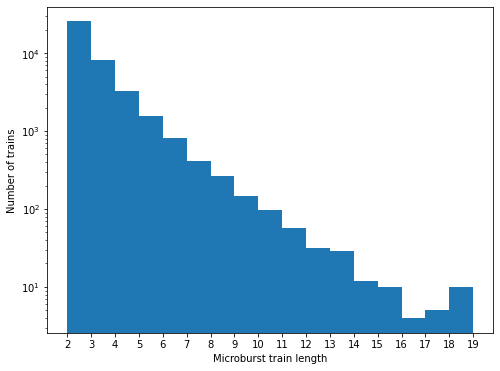

In [17]:
train_bins = np.arange(2, 20)
fig, cx = plt.subplots(figsize=(8,6))
cx.hist(trains['n_microbursts'], bins=train_bins)
cx.set_xticks(train_bins)
cx.set(xlabel='Microburst train length', ylabel='Number of trains');
cx.set_yscale('log')

# L-MLT distribution

/home/mike/research/sampex_microburst_indices/sampex_microburst_indices/analysis/dial.py:73: UserWarning: FixedFormatter should only be used together with FixedLocator
  self.ax.set_xticklabels(mlt_labels) # Transform back from 0->2pi to 0->24.


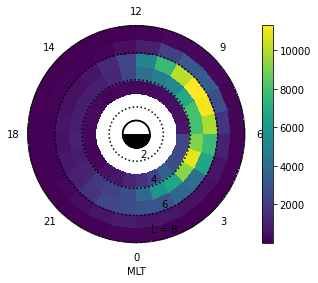

In [25]:
L_bins = np.arange(3, 9)
MLT_bins = np.arange(0, 24.1)

H, _, _ = np.histogram2d(cat['MLT'], cat['L_Shell'], bins=[MLT_bins, L_bins])

fig, dx = plt.subplots(subplot_kw={'projection': 'polar'})
d = Dial(dx, MLT_bins, L_bins, H)
d.draw_earth()
d.draw_dial()